In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sys.path.append("../src")

from data_preprocessing import DataLoader
from chunking_embedding import ComplaintSampler, TextChunker, VectorStoreBuilder, VectorStoreSearcher

sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
loader = DataLoader()
df_clean = loader.load_data("../data/processed/filtered_complaints.csv")

print(f"Total cleaned complaints available: {len(df_clean)}")
df_clean.head(2)

Total cleaned complaints available: 475879


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,product_category,narrative_length,cleaned_narrative
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,78230,...,Consent provided,Web,2025-06-13,Closed with non-monetary relief,Yes,NaN,14069121,Credit Card,91,a redacted redacted card was opened under my n...
1,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,ID,83815,...,Consent provided,Web,2025-06-13,Closed with explanation,Yes,NaN,14061897,Savings Account,109,i made the mistake of using my wellsfargo debi...


### Stratified Sampling

In [3]:
sampler = ComplaintSampler(df_clean, product_col="product_category")
df_sample = sampler.stratified_sample(n_samples=15000)

print("--- Stratified Sample Distribution ---")
print(df_sample['product_category'].value_counts())

--- Stratified Sample Distribution ---
product_category
Credit Card        5968
Savings Account    4423
Money Transfer     3063
Personal Loan      1546
Name: count, dtype: int64


#### Visualization to confirm stratification


/var/folders/cm/vngd5r7d2x16wjb2nxg9h5mc0000gn/T/ipykernel_68905/1790732568.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


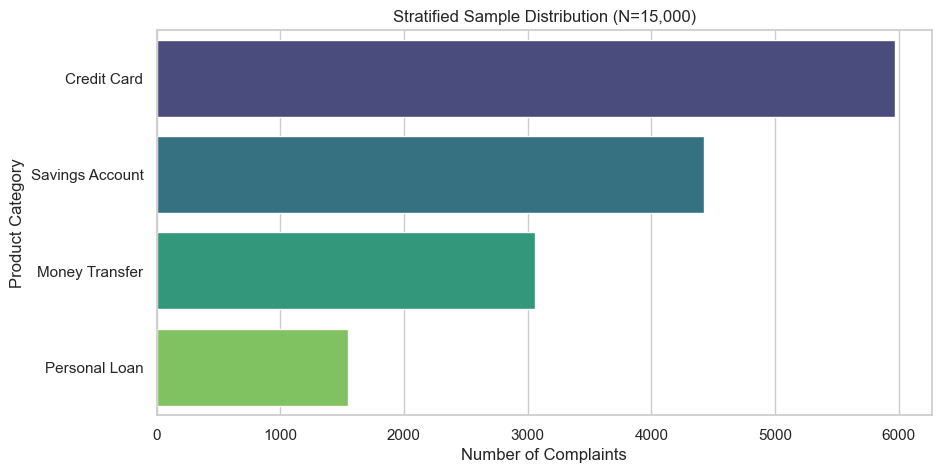

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(
    y=df_sample['product_category'].value_counts().index,
    x=df_sample['product_category'].value_counts().values,
    palette='viridis'
)
plt.xlabel("Number of Complaints")
plt.ylabel("Product Category")
plt.title(f"Stratified Sample Distribution (N=15,000)")
plt.show()


### Text chunking

In [5]:
chunker = TextChunker(chunk_size=500, chunk_overlap=50)
df_chunks = chunker.chunk_dataframe(df_sample, text_col="cleaned_narrative")

print(f"Total chunks created: {len(df_chunks)}")
print(f"Average chunks per complaint: {len(df_chunks)/len(df_sample):.2f}")
df_chunks.head()

Total chunks created: 45765
Average chunks per complaint: 3.05


,complaint_id,product_category,chunk_text,chunk_index,total_chunks
0,8353009,Checking or savings account,wells fargo has decided out of nowhere to clos...,0,2
1,8353009,Checking or savings account,valid claims that makes zero sense and now the...,1,2
2,8541878,"Money transfer, virtual currency, or money ser...",redactedredactedredacted redactedredactedredac...,0,1
3,8119461,Checking or savings account,heres what bothers me in my previous complaint...,0,3
4,8119461,Checking or savings account,to see the complaint or response in my dashboa...,1,3


#### Visualize chunk distribution

In [17]:
print(f"Total complaints in sample: {len(df_sample)}")
print(f"Total chunks created: {len(df_chunks)}")
print(f"Average chunks per complaint: {len(df_chunks)/len(df_sample):.2f}")

Total complaints in sample: 15000
Total chunks created: 45765
Average chunks per complaint: 3.05


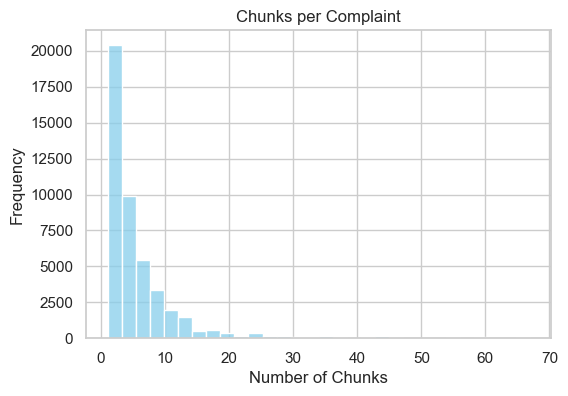

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(df_chunks['total_chunks'], bins=30, color='skyblue', kde=False)
plt.title("Chunks per Complaint")
plt.xlabel("Number of Chunks")
plt.ylabel("Frequency")
plt.show()



### Generate Embeddings

In [7]:
vector_builder = VectorStoreBuilder(model_name="sentence-transformers/all-MiniLM-L6-v2")

print("Generating embeddings for chunks... (This may take a few minutes)")
embeddings = vector_builder.create_embeddings(df_chunks, text_col="chunk_text")

print(f"Embeddings generated with shape: {embeddings.shape}")


Generating embeddings for chunks... (This may take a few minutes)


Batches:   0%|          | 0/1431 [00:00<?, ?it/s]

Embeddings generated with shape: (45765, 384)


### Build FAISS vector store

In [8]:
vector_builder.build_faiss_index(
    embeddings, 
    df_chunks, 
    save_path="../vector_store"
)

print("SUCCESS: FAISS index and metadata.parquet saved to ../vector_store")

SUCCESS: FAISS index and metadata.parquet saved to ../vector_store


### Sanity Check (Verification)

In [9]:
# Initialize searcher
searcher = VectorStoreSearcher(index_path="../vector_store")

In [10]:
# Perform test search
test_query = "unauthorized credit card charges"
results = searcher.search(test_query, k=3)

print(f"--- Top matches for: '{test_query}' ---\n")
for idx, row in results.iterrows():
    print(f"Score: {row['score']:.4f} | Category: {row['product_category']}")
    print(f"Content: {row['chunk_text'][:200]}...\n")

--- Top matches for: 'unauthorized credit card charges' ---

Score: 0.7553 | Category: Credit card
Content: my credit card was lost i noticed some unauthorized charges appeared on my statement i notified the credit company regarding the unauthorized charges but they denied the claim...

Score: 0.7440 | Category: Credit card or prepaid card
Content: i did not have the credit card in my physical presence and eyesight the entire time i was in redacted redactedredactedredactedredactedredactedredacted i handed the card over to merchants on several oc...

Score: 0.7264 | Category: Credit card
Content: unauthorized credit card charges were made on my discover credit card i immediately called and reported the card lost and filed a police report discover is refusing to refund the unauthorized fraudule...

